In [ ]:
# Imports básicos
import numpy as np
from numpy import random
import pandas as pd
import math
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')
random.RandomState(1)
 
# Imports scikit-learn
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import make_blobs, make_moons
from sklearn.metrics import accuracy_score
 
# Imports pytroch
import torch
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data_utils
import torchvision
from torchvision import datasets, models, transforms
import torchvision.transforms.functional as TF
from PIL import Image as Pil_Image
 
# Imports para plots
import matplotlib.pyplot as plt
%matplotlib inline

<img src="https://www.ifsc.edu.br/image/layout_set_logo?img_id=1319584&t=1602803233260" width="20%">

<center>

---
# **Introdução a Redes Neurais para Classificação**
## Implementação em Python com Pytorch (Parte 3)
## <u>Prof. Carlos Andres Ferrero</u>
## Instituto Federal de Santa Catarina (IFSC), Câmpus Lages
## Grupo de Pesquisa em Análise Inteligente de Dados (IDA-IFSC)
## *Semana Nacional de Ciência e Tecnologia (SNCT/IFSC)*
---
</center>

# 0 - Entender o Problema de Classificação e os Dados Disponíveis

## Baixando e carregando o conjunto de dados

Os dados foram extraídos do seguinte conjunto de dados na plataforma Kaggle: https://www.kaggle.com/prithwirajmitra/covid-face-mask-detection-dataset

Esses dados foram baixados e posicionados em um link do Dropbox para facilitar baixar e utilizar as imagens.


In [ ]:
# Criar pasta para armazenar os dados
!mkdir -p covid-face-mask-detection-dataset
# Baixar e descompactar dados de treino
!wget -q https://www.dropbox.com/s/tvc6os8fvwxifed/Train.zip -O covid-face-mask-detection-dataset/Train.zip
!unzip -o -q covid-face-mask-detection-dataset/Train.zip -d covid-face-mask-detection-dataset/
# Baixar e descompactar dados de teste
!wget -q https://www.dropbox.com/s/r6xoz38nszc6f5k/Test.zip -O covid-face-mask-detection-dataset/Test.zip
!unzip -o -q covid-face-mask-detection-dataset/Test.zip -d covid-face-mask-detection-dataset/

**Transformadores de Imagem** são usados para transformar conjuntos de dados de imagem de forma padronizada. Essas transformações também podem usar informações aleatórias para inserir variabilidade durante a etapa treinamento do modelo (não usaremos isso nesta oportunidade).

In [ ]:
height = 224
width = 224
input_size = (height,width)
data_transforms = {
  'train' : transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),                                            
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                                    
        ]),
  'test'   : transforms.Compose([
        transforms.Resize(input_size),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}
  
train_data=datasets.ImageFolder('covid-face-mask-detection-dataset/Train', transform=data_transforms['train'])
test_data=datasets.ImageFolder('covid-face-mask-detection-dataset/Test', transform=data_transforms['test'])

**Data Loaders** são usados para obter subconjuntos de imagens tamanho pré-definido (*batch_size*) escolhidos aleatoriamente.

In [ ]:
batch_size = 16
train_loader = data_utils.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = data_utils.DataLoader(test_data, batch_size=batch_size, shuffle=False)

**Iteradores** são usados para acessar subconjuntos de imagens de *Data Loaders*

In [ ]:
train_iter = iter(train_loader)

In [ ]:
images, labels = next(train_iter)
print('Shape de images:', images.shape)
print('Shape de labels:', labels.shape)

Shape de images: torch.Size([16, 3, 224, 224])
Shape de labels: torch.Size([16])


No shape de images o primeiro valor indica o número de imagens do subconjunto (batch), o segundo valor o número de canais (1 em GrayScale e 3 em RGB, por exemplo) e os últimos dois valores são as dimensões da imagem.

No shape de labels o valor indica o número de labels, um para cada imagem.

**Mostrar uma imagem**

Ao mostrar uma imagem usando a biblioteca *matplotlib* temos que transformar as dimensões da imagem, posicionando o número de canais como a última dimensão, por ex., de \[3, 32, 32\] para \[32, 32, 3\].

Classes:
- Classe 0 - Com máscara
- Classe 1 - Sem máscara

In [ ]:
# TODO - Criar um dicionário para significado das classes
label_desc = {0 : 'com máscara', 1 : 'sem máscara'}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


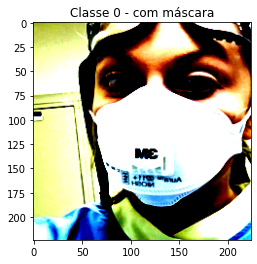

In [ ]:
i = 0
plt.imshow(images[i].permute(1, 2, 0).squeeze())
plt.title('Classe %i - %s' % (labels[i], label_desc[ labels.detach().numpy()[i] ] ))
plt.show()

**Mostrar várias imagens**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

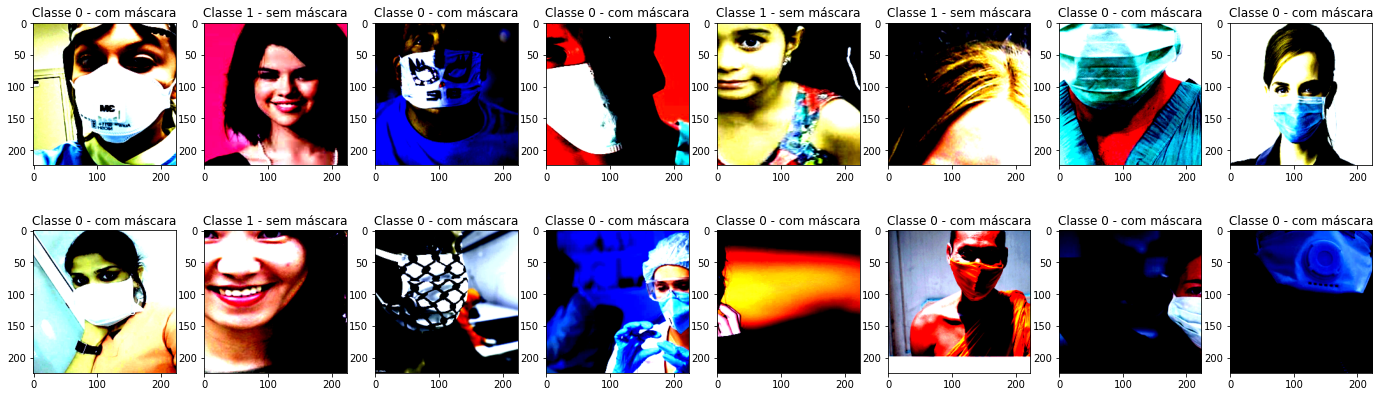

In [ ]:
fig = plt.figure(figsize=(24, 7))
rows = 2
columns = math.ceil(batch_size / rows)

for i in range(0, columns*rows):
    img = images[i].permute(1, 2, 0).squeeze()
    fig.add_subplot(rows, columns, i+1, title = 'Classe %i - %s' % (labels[i], label_desc[ labels.detach().numpy()[i] ] ) )
    plt.imshow(img)

# 1 - Definição de Arquitetura



In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)

CUDA is available!  Training on GPU ...
device cuda:0


**Implementação da Rede Neural**

In [ ]:
# code from https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
 
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0
 
    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
 
    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
 
    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224
 
    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
 
    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224
 
    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
 
    else:
        print("Invalid model name, exiting...")
        exit()
 
    return model_ft, input_size

In [ ]:
model_name = 'vgg'
num_classes = 2
feature_extract = True
use_pretreined = True

In [ ]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained = use_pretreined)

# Print the model we just instantiated
print(model_ft)

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(k

In [ ]:
model_ft.to(device)
from torchsummary import summary
summary(model_ft, (3, height, width))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
       BatchNorm2d-2         [-1, 64, 224, 224]             128
              ReLU-3         [-1, 64, 224, 224]               0
         MaxPool2d-4         [-1, 64, 112, 112]               0
            Conv2d-5        [-1, 128, 112, 112]          73,856
       BatchNorm2d-6        [-1, 128, 112, 112]             256
              ReLU-7        [-1, 128, 112, 112]               0
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 256, 56, 56]         295,168
      BatchNorm2d-10          [-1, 256, 56, 56]             512
             ReLU-11          [-1, 256, 56, 56]               0
           Conv2d-12          [-1, 256, 56, 56]         590,080
      BatchNorm2d-13          [-1, 256, 56, 56]             512
             ReLU-14          [-1, 256,

In [ ]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [ ]:
_, y_pred = torch.max(model_ft(images.cuda()),1)
y_pred

tensor([0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')

In [ ]:
y = labels.cuda()
y

tensor([0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], device='cuda:0')

# 2 - Treinamento / Avaliação

In [ ]:
def train_epoch(model, trainLoader, optimizer, criterion):
    model.train()
    losses = []
    for X, y in trainLoader:    
        X, y = X.to(device), y.to(device)            
        optimizer.zero_grad()
        # (1) Passar os dados pela rede neural (forward)
        output = model(X)                              
        # (2) Calcular o erro da saída da rede com a classe das instâncias (loss)                    
        loss = criterion(output, y)        
        # (3) Usar o erro para calcular quanto cada peso (wi) contribuiu com esse erro (backward)
        loss.backward()
        # (4) Ataulizar os pesos da rede neural
        optimizer.step()        
        losses.append(loss.item())        
    model.eval()
    return np.mean(losses)

def eval_model(model, loader):
    measures = []
    total = 0
    correct = 0
    for X, y in loader:                
        X, y = X.to(device), y.to(device)             
        output = model(X)                      
        _, y_pred = torch.max(output, 1)
        total += len(y)
        correct += (y_pred == y).sum().cpu().data.numpy()
    measures = {'acc' : correct/total}
    return measures

def train_and_evaluate(model, num_epochs, train_loader, test_loader, optimizer, criterion):
  
  e_measures = []
  pbar = tqdm(range(1,num_epochs+1))
  for e in pbar:
      losses =  train_epoch(model, train_loader, optimizer, criterion)
      measures_on_train = eval_model(model, train_loader)
      measures_on_test  = eval_model(model, test_loader )
      train_loss = np.mean(losses)
      measures = {'epoch': e, 'train_loss': train_loss, 'train_acc' : measures_on_train['acc'].round(2), 'test_acc' : measures_on_test['acc'].round(2) }   
      pbar.set_postfix(measures)     
      e_measures += [measures]
  return pd.DataFrame(e_measures)   

In [ ]:
criterion = nn.CrossEntropyLoss()  
train_epoch(model_ft, train_loader, optimizer_ft, criterion)

0.39849389266026647

In [ ]:
eval_model(model_ft, test_loader)

{'acc': 0.94}

In [ ]:
# TODO - Definir o número de epocas de treinamento
num_epochs = 10
# TODO - Executar o treinamento da rede neural
train_and_evaluate(model_ft, num_epochs, train_loader, test_loader, optimizer_ft, criterion)  

,epoch,train_loss,train_acc,test_acc
0,1,0.175557,0.97,0.94
1,2,0.161070,0.97,0.95
2,3,0.146903,0.97,0.96
3,4,0.164560,0.96,0.95
4,5,0.135536,0.96,0.94
5,6,0.154028,0.97,0.96
6,7,0.111988,0.98,0.96
7,8,0.141796,0.97,0.96
8,9,0.142813,0.97,0.96
9,10,0.138144,0.97,0.96


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

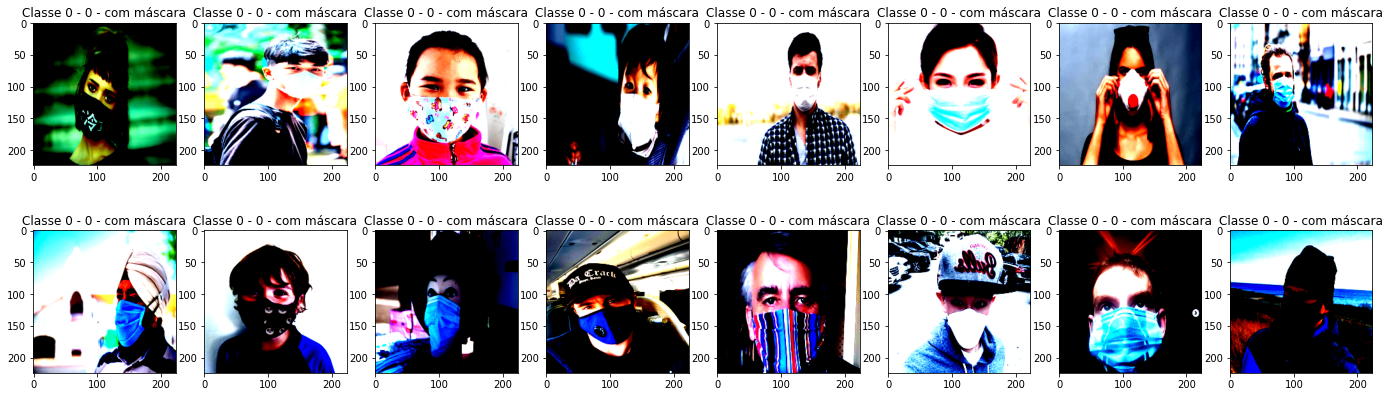

In [ ]:
test_iter = iter(test_loader)
images, labels = next(test_iter)

fig = plt.figure(figsize=(24, 7))
rows = 2
columns = math.ceil(batch_size / rows)

output = model_ft(images.to(device))
_, y_pred = torch.max(output, 1)
y_pred = y_pred.cpu().data.numpy()
for i in range(0, columns*rows):    
    img = images[i].permute(1, 2, 0).squeeze()    
    fig.add_subplot(rows, columns, i+1, title = 'Classe %i - %i - %s' % (labels[i], y_pred[i], label_desc[ y_pred[i] ] ) )
    plt.imshow(img)

# 3 - Avaliação: com Dados Reais

## Captura de Imagem da Webcam

Usar o Snippet do Google Colab para captura de imagem

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=1.0):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


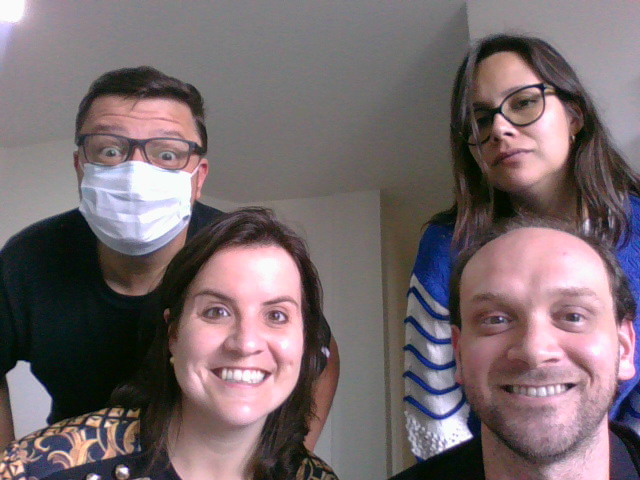

Saída da rede neural: tensor([[-0.0895,  0.2940]], device='cuda:0', grad_fn=<AddmmBackward>)
Classe 1 - sem máscara


In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  img = Image(filename)
  display(img)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# TODO - Abrir a imagem salva e redimensionar
image_pil = Pil_Image.open(filename)

transform_new_images = transforms.Compose([
        transforms.Resize(input_size),        
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
image = transform_new_images(image_pil)

# TODO - Tranformar a imagem para o formato da rede
X = image.unsqueeze(0)
X = X.to(device)

# TODO - Executar o modelo treinado
output = model_ft(X)
_, y_pred = torch.max(output, 1)
y_pred_class_desc = label_desc[ y_pred.cpu().data.numpy()[0] ]

# TODO - Mostrar a Saída rede neural e a classe
print('Saída da rede neural:', output)
print('Classe %i - %s' % (y_pred, y_pred_class_desc) )

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

import cv2
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

--2020-10-24 19:51:02--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.03s   

2020-10-24 19:51:02 (26.0 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



tensor([0], device='cuda:0')
tensor([[0.3219, 0.1574]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([1], device='cuda:0')
tensor([[-1.9280,  2.0945]], device='cuda:0', grad_fn=<AddmmBackward>)
tensor([1], device='cuda:0')
tensor([[-1.9946,  2.3210]], device='cuda:0', grad_fn=<AddmmBackward>)


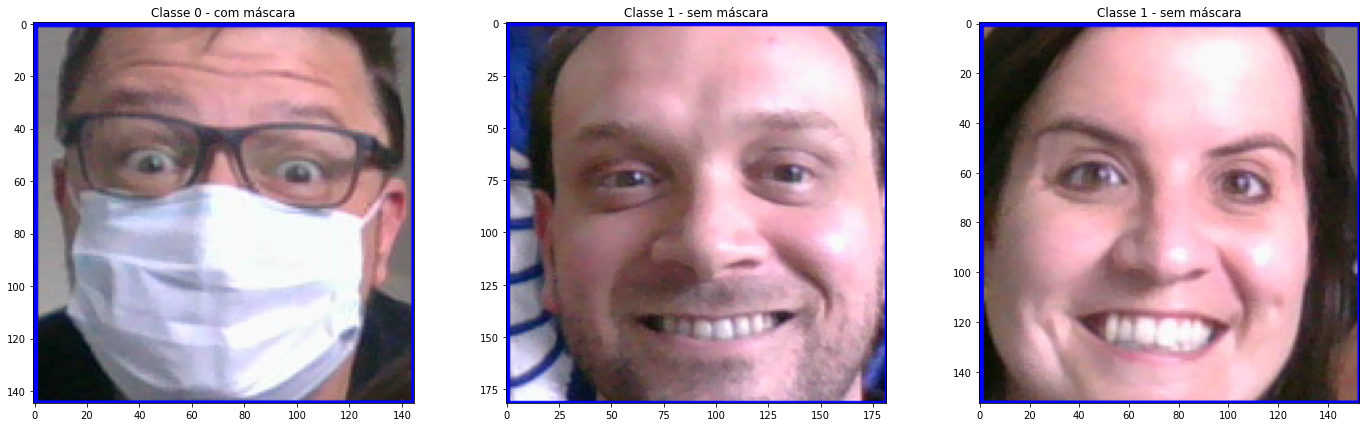

In [ ]:
fig = plt.figure(figsize=(24, 7))

cv_image = cv2.imread(filename)
grey = cv2.cvtColor(cv_image, cv2.COLOR_BGR2GRAY) 
faces = face_cascade.detectMultiScale(grey, 1.3, 5)
for i, (x,y,w,h) in enumerate(faces):
    cv2.rectangle(cv_image,(x,y),(x+w,y+h),(255,0,0),2)
    roi_image = cv_image[y:y + h, x:x + w]

    image = transform_new_images(transforms.ToPILImage()(roi_image))
    X = image.unsqueeze(0)
    output = model_ft(X.to(device))
    _, y_pred = torch.max(output, 1)
    print(y_pred)
    y_pred_class_desc = label_desc[ y_pred.cpu().data.numpy()[0] ]
    print(output)
    fig.add_subplot(1, len(faces), i+1, title = 'Classe %i - %s' % (y_pred, y_pred_class_desc ) )
    plt.imshow(cv2.cvtColor(roi_image, cv2.COLOR_BGR2RGB))